In [1]:
import pandas as pd
!pip install shapely

DEPRECATION: pandas 0.23.4 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%run ROUTINES/gauss_asym.py

In [3]:
%matplotlib widget

## Load fit info

In [4]:
#df_fits = pd.read_csv('fit_info/fit_sobrevivientes_rho_arm2.csv')

id_halo='11'
df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv')
df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis = 1)
df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis = 1)

In [5]:
df_fits.tail(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
30,0.000105,5.826406,0.05,False,1.442484,30.0,0.744739,0.000004,0.095325,0.633526,0.097211,"[5.236574737822774, 5.425428775768558, 5.49628...",-6.637987,"[6.020357140752003e-06, 8.162365296521914e-06,...",-2.370536
31,0.000102,5.872949,0.05,False,2.751502,31.0,0.852442,0.000007,0.060731,1.093969,0.106182,"[5.529847409963715, 5.597076144752718, 5.63527...",-6.715909,"[3.085822426266149e-05, 2.719977459358204e-05,...",-0.890016
32,0.000070,7.057400,0.05,False,-5.201747,32.0,0.681829,0.000005,0.029657,2.339877,0.085424,"[5.884338996009094, 5.962868330964022, 6.06310...",-6.832792,"[1.0466782838921967e-05, 1.2863078455568175e-0...",0.239854


In [6]:
params = df_fits.iloc[0] # Para investigar los resultado del fit de un punto, llamamos su fila en el DataFrame

In [7]:
params

amplitude                                                 7.63275e-05
center                                                        1.10078
delta                                                            0.05
fractured                                                       False
gamma                                                         3.31403
id_tracing                                                          0
sigma                                                        0.800582
stderr_amplitude                                          4.07807e-06
stderr_center                                               0.0337086
stderr_gamma                                                  1.36904
stderr_sigma                                                0.0787316
x                   [1.0531389868545593, 1.1309191393479958, 1.158...
x_tracing                                                     1.11526
y                   [3.660864705582006e-05, 4.215183384509996e-05,...
y_tracing           

In [8]:
#import numpy as np

# Convertir las columnas 'x' y 'y' de cadenas a arrays numéricos
#params['x'] = np.array(params['x'].split('\\n'), dtype=float)
#params['y'] = np.array(params['y'].split('\\n'), dtype=float)

# Verificar los resultados
#print("X values:", params['x'])
#print("Y values:", params['y'])


In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [10]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [11]:
params['x']

[1.0531389868545593,
 1.1309191393479958,
 1.1585512967696379,
 1.2165566145992757,
 1.259951157398631,
 1.3125127942136163,
 1.3704168054648702,
 1.4277795270614406,
 1.4773940241205052,
 1.5369776990763664,
 1.585798877627162,
 1.6326031439992468,
 1.6797792542750598,
 1.7271038815039255,
 1.7699726874010338,
 1.8226179156164464,
 1.8858658346021362,
 1.937801357920746,
 1.9702747308606048,
 2.0243484800612235,
 2.0847081854062086,
 2.135183466697728,
 2.1678427350839424,
 2.237315022549258,
 2.287128951549628,
 2.357759768286176]

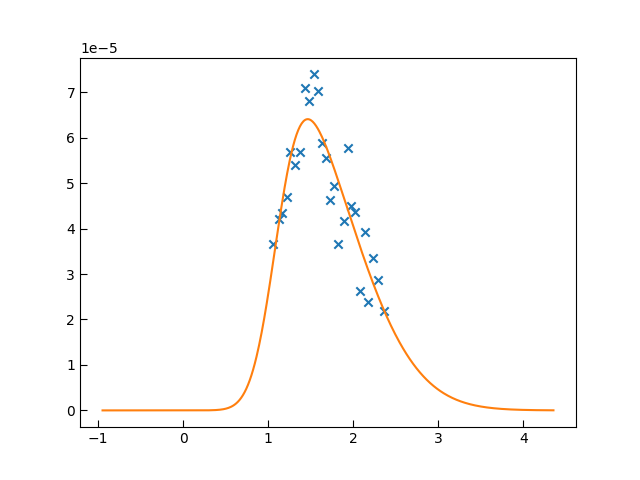

In [12]:

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficamos el fit y los puntos con los que se hizo el fit
fig, ax = plt.subplots()
ax.scatter(params.x, params.y, color = 'C0', marker = 'x') # Envoltorio
model_eval = eval_fitted_model_with_given_params(params, dx = 0.01) # Funcion en gauss_asym.py
x_eval = model_eval['x_eval']
y_eval = model_eval['y_eval']
ax.plot(x_eval, y_eval,color = 'C1'); # Fit

## Calculate width of a fit

In [13]:
%run ROUTINES/gauss_asym.py

In [14]:
dx = 0.001 # Discretizacion para mapear la gaussiana

In [15]:
width_info = find_widths_of_skewed_gaussian_dani(params, dx = dx) # Funcion en gauss_asym.py

In [16]:
width_info # Retorna la ubicacion del maximo (x_max, y_max) y el ancho a la izquierda (w1) y a la derecha (w2)

{'x_max': 1.4651389868545615,
 'y_max': 6.407718005198354e-05,
 'w1': 0.41194507994652874,
 'w2': 0.6884685964659736}

In [17]:
#fig, ax = plt.subplots(figsize=(10,5))
#plot_fit_and_widths(params, ax, dx = dx) # Funcion en gauss_asym.py

In [18]:
# Podemos aplicar find_widths_of_skewed_gaussian() a toda la tabla con la informacion de los parametros 

df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [19]:


df_fits.head(10)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000076,1.100783,0.05,False,3.314027,0.0,0.800582,0.000004,0.033709,1.369042,0.078732,"[1.0531389868545593, 1.1309191393479958, 1.158...",1.115260,"[3.660864705582006e-05, 4.215183384509996e-05,...",0.824269,"{'x_max': 1.4651389868545615, 'y_max': 6.40771...",1.465139,0.000064,0.411945,0.688469
1,0.000051,0.871990,0.05,False,1.994018,1.0,0.606178,0.000052,0.400654,7.892719,0.196534,"[1.0981897287359714, 1.1516658792975394, 1.198...",1.232143,"[5.0115605255302986e-05, 5.7126940830650164e-0...",0.200893,"{'x_max': 1.1941897287359733, 'y_max': 5.02055...",1.194190,0.000050,0.418229,0.529932
2,0.000027,1.059887,0.05,False,1.548838,2.0,0.325805,0.000007,0.174439,3.875247,0.203531,"[1.0246076336086145, 1.1229963510560774, 1.174...",1.271104,"[2.5913903287833956e-05, 4.49269817773002e-05,...",-0.383523,"{'x_max': 1.2366076336086165, 'y_max': 4.52767...",1.236608,0.000045,0.254850,0.295753
3,0.000094,0.989271,0.05,False,-0.007712,4.0,0.691054,0.000295,15710.193278,28505.286967,234.933110,"[1.066051845125667, 1.1169859086225353, 1.1650...",-0.637987,"[5.669878538619095e-05, 5.7949333853416975e-05...",-1.123782,"{'x_max': 0.9850518451256689, 'y_max': 5.44195...",0.985052,0.000054,0.813672,0.813606
4,0.000056,1.124091,0.05,False,11.050451,5.0,0.981666,0.000008,0.061417,10.410713,0.193507,"[1.074725249172557, 1.2239679540309005, 1.2725...",-1.378247,"[1.4061952941731587e-05, 3.286830570917144e-05...",-0.071834,"{'x_max': 1.341725249172559, 'y_max': 4.372887...",1.341725,0.000044,0.221113,0.964361
5,0.000066,1.013858,0.05,False,4.472738,6.0,0.955734,0.000016,0.127183,7.250746,0.394686,"[1.0566886801979156, 1.1020521805023606, 1.182...",-1.300325,"[3.9447691113646336e-05, 3.6339962711142446e-0...",0.902192,"{'x_max': 1.390688680197918, 'y_max': 4.880670...",1.390689,0.000049,0.406479,0.840041
6,0.000100,1.131881,0.05,False,5.579120,7.0,1.328062,0.000012,0.067463,3.563686,0.262230,"[1.0390329422802398, 1.089300196608018, 1.1336...",-0.871753,"[2.610137118179518e-05, 2.3366385743371645e-05...",1.369724,"{'x_max': 1.5940329422802422, 'y_max': 5.52466...",1.594033,0.000055,0.487006,1.196749
7,0.000095,1.124545,0.05,False,16.470138,8.0,1.392556,0.000018,0.043433,14.410655,0.350381,"[1.0584891206289964, 1.1123498069879363, 1.184...",-0.443182,"[1.6001854180740528e-05, 2.36683525439078e-05,...",1.525568,"{'x_max': 1.3544891206289984, 'y_max': 5.32924...",1.354489,0.000053,0.231721,1.429540
8,0.000085,2.856575,0.05,False,-4.966858,9.0,1.127564,0.000019,0.093958,4.476995,0.423762,"[1.4646651148106962, 1.6741992535810815, 1.683...",0.569805,"[1.710133802014321e-05, 2.5733099112251323e-05...",1.876218,"{'x_max': 2.4376651148106987, 'y_max': 5.40708...",2.437665,0.000054,1.003072,0.446504
9,0.000119,3.016282,0.05,False,-0.870829,10.0,1.081778,0.000012,1.590958,3.804473,1.079662,"[1.1595572316030305, 1.3094769666135442, 1.399...",1.777597,"[1.1502160386099793e-05, 2.4723727689678684e-0...",1.954140,"{'x_max': 2.4965572316030333, 'y_max': 5.18410...",2.496557,0.000052,1.099022,1.054688


In [20]:
df_fits

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000076,1.100783,0.05,False,3.314027,0.0,0.800582,0.000004,0.033709,1.369042,0.078732,"[1.0531389868545593, 1.1309191393479958, 1.158...",1.115260,"[3.660864705582006e-05, 4.215183384509996e-05,...",0.824269,"{'x_max': 1.4651389868545615, 'y_max': 6.40771...",1.465139,0.000064,0.411945,0.688469
1,0.000051,0.871990,0.05,False,1.994018,1.0,0.606178,0.000052,0.400654,7.892719,0.196534,"[1.0981897287359714, 1.1516658792975394, 1.198...",1.232143,"[5.0115605255302986e-05, 5.7126940830650164e-0...",0.200893,"{'x_max': 1.1941897287359733, 'y_max': 5.02055...",1.194190,0.000050,0.418229,0.529932
2,0.000027,1.059887,0.05,False,1.548838,2.0,0.325805,0.000007,0.174439,3.875247,0.203531,"[1.0246076336086145, 1.1229963510560774, 1.174...",1.271104,"[2.5913903287833956e-05, 4.49269817773002e-05,...",-0.383523,"{'x_max': 1.2366076336086165, 'y_max': 4.52767...",1.236608,0.000045,0.254850,0.295753
3,0.000094,0.989271,0.05,False,-0.007712,4.0,0.691054,0.000295,15710.193278,28505.286967,234.933110,"[1.066051845125667, 1.1169859086225353, 1.1650...",-0.637987,"[5.669878538619095e-05, 5.7949333853416975e-05...",-1.123782,"{'x_max': 0.9850518451256689, 'y_max': 5.44195...",0.985052,0.000054,0.813672,0.813606
4,0.000056,1.124091,0.05,False,11.050451,5.0,0.981666,0.000008,0.061417,10.410713,0.193507,"[1.074725249172557, 1.2239679540309005, 1.2725...",-1.378247,"[1.4061952941731587e-05, 3.286830570917144e-05...",-0.071834,"{'x_max': 1.341725249172559, 'y_max': 4.372887...",1.341725,0.000044,0.221113,0.964361
5,0.000066,1.013858,0.05,False,4.472738,6.0,0.955734,0.000016,0.127183,7.250746,0.394686,"[1.0566886801979156, 1.1020521805023606, 1.182...",-1.300325,"[3.9447691113646336e-05, 3.6339962711142446e-0...",0.902192,"{'x_max': 1.390688680197918, 'y_max': 4.880670...",1.390689,0.000049,0.406479,0.840041
6,0.000100,1.131881,0.05,False,5.579120,7.0,1.328062,0.000012,0.067463,3.563686,0.262230,"[1.0390329422802398, 1.089300196608018, 1.1336...",-0.871753,"[2.610137118179518e-05, 2.3366385743371645e-05...",1.369724,"{'x_max': 1.5940329422802422, 'y_max': 5.52466...",1.594033,0.000055,0.487006,1.196749
7,0.000095,1.124545,0.05,False,16.470138,8.0,1.392556,0.000018,0.043433,14.410655,0.350381,"[1.0584891206289964, 1.1123498069879363, 1.184...",-0.443182,"[1.6001854180740528e-05, 2.36683525439078e-05,...",1.525568,"{'x_max': 1.3544891206289984, 'y_max': 5.32924...",1.354489,0.000053,0.231721,1.429540
8,0.000085,2.856575,0.05,False,-4.966858,9.0,1.127564,0.000019,0.093958,4.476995,0.423762,"[1.4646651148106962, 1.6741992535810815, 1.683...",0.569805,"[1.710133802014321e-05, 2.5733099112251323e-05...",1.876218,"{'x_max': 2.4376651148106987, 'y_max': 5.40708...",2.437665,0.000054,1.003072,0.446504
9,0.000119,3.016282,0.05,False,-0.870829,10.0,1.081778,0.000012,1.590958,3.804473,1.079662,"[1.1595572316030305, 1.3094769666135442, 1.399...",1.777597,"[1.1502160386099793e-05, 2.4723727689678684e-0...",1.954140,"{'x_max': 2.4965572316030333, 'y_max': 5.18410...",2.496557,0.000052,1.099022,1.054688


## Results

In [21]:
df_tracing_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_tracing_arm1['arm'] = [1]*len(df_tracing_arm1)
df_tracing_arm1['id'] = np.arange(0,len(df_tracing_arm1),1)

df_tracing_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_tracing_arm2['arm'] = [2]*len(df_tracing_arm2)
df_tracing_arm2['id'] = np.arange(0,len(df_tracing_arm2),1)

df_arms = pd.concat([df_tracing_arm1,df_tracing_arm2], axis = 0).reset_index(drop=True)

In [22]:
df_arms

,x,y,arm,id
0,1.115260,0.824269,1,0
1,1.232143,0.200893,1,1
2,1.271104,-0.383523,1,2
3,0.608766,-1.084821,1,3
4,-0.637987,-1.123782,1,4
5,-1.378247,-0.071834,1,5
6,-1.300325,0.902192,1,6
7,-0.871753,1.369724,1,7
8,-0.443182,1.525568,1,8
9,0.569805,1.876218,1,9


In [25]:
# Aplicar la función en las columnas 'x' y 'y'
dfs = []
for i, arm in enumerate(['arm1', 'arm2']):
    df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_{arm}_all_points_HALO{id_halo}_.csv')
    
    # Aplicar la limpieza y conversión en las columnas 'x' y 'y'
    df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis=1)
    df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis=1)
    print(i,arm)
    
    # Añadir la columna 'arm'
    df_fits['arm'] = [i+1] * len(df_fits)
    
    dfs.append(df_fits)



0 arm1
1 arm2


In [26]:
dfs

[    amplitude    center  delta  fractured      gamma  id_tracing     sigma  \
 0    0.000076  1.100783   0.05      False   3.314027         0.0  0.800582   
 1    0.000051  0.871990   0.05      False   1.994018         1.0  0.606178   
 2    0.000027  1.059887   0.05      False   1.548838         2.0  0.325805   
 3    0.000094  0.989271   0.05      False  -0.007712         4.0  0.691054   
 4    0.000056  1.124091   0.05      False  11.050451         5.0  0.981666   
 5    0.000066  1.013858   0.05      False   4.472738         6.0  0.955734   
 6    0.000100  1.131881   0.05      False   5.579120         7.0  1.328062   
 7    0.000095  1.124545   0.05      False  16.470138         8.0  1.392556   
 8    0.000085  2.856575   0.05      False  -4.966858         9.0  1.127564   
 9    0.000119  3.016282   0.05      False  -0.870829        10.0  1.081778   
 10   0.000143  3.696467   0.05      False  -1.822136        11.0  0.998060   
 11   0.000122  3.870875   0.05      False  -6.31830

In [27]:
df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [28]:
 df_fits['arm'].nunique()

2

In [29]:
fits_arm1 = df_fits[df_fits.arm == 1]
fits_arm2 = df_fits[df_fits.arm == 2]

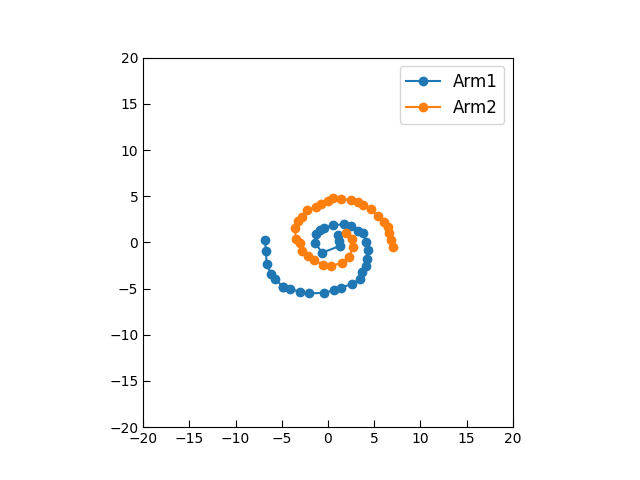

In [30]:

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig, ax = plt.subplots()
ax.plot(fits_arm1.x_tracing, fits_arm1.y_tracing, marker = 'o', label = 'Arm1')
ax.plot(fits_arm2.x_tracing, fits_arm2.y_tracing, marker = 'o', label = 'Arm2')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.legend()
ax.set_aspect('equal')

In [31]:
def calc_euclidean(x1,y1,x2,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [32]:
dist_previous = []
for i in range(len(df_tracing_arm2)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm2.iloc[i-1].x
        y1 = df_tracing_arm2.iloc[i-1].y
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))

In [33]:
df_tracing_arm2['dist_previous'] = dist_previous
df_tracing_arm2['arm_length'] = df_tracing_arm2.dist_previous.cumsum()



In [34]:
df_tracing_arm2

,x,y,arm,id,dist_previous,arm_length
0,7.037338,-0.500406,2,0,7.055106,7.055106
1,6.842532,0.239854,2,1,0.765463,7.820569
2,6.647727,1.058036,2,2,0.841053,8.661623
3,6.491883,1.642451,2,3,0.604838,9.266461
4,6.024351,2.226867,2,4,0.748417,10.014878
5,5.362013,2.811282,2,5,0.883308,10.898186
6,4.699675,3.590503,2,6,1.022681,11.920867
7,3.764610,4.096997,2,7,1.063429,12.984296
8,3.258117,4.369724,2,8,0.575253,13.559549
9,2.439935,4.564529,2,9,0.841053,14.400602


In [35]:
def assign_length(id_tracing, df_tracing):
    length = df_tracing[df_tracing.id == id_tracing].arm_length.values[0]
    return length

In [36]:
fits_arm2['arm_length'] = fits_arm2.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm2), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
fits_arm2

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,...,y,y_tracing,arm,r_tracing,width_info,x_max,y_max,w1,w2,arm_length
33,0.000036,6.345431,0.05,False,1.382571,0.0,0.542836,0.000003,0.179707,1.386284,...,"[6.225138528796177e-06, 7.294953548256233e-06,...",-0.500406,2,7.055106,"{'x_max': 6.638605583416461, 'y_max': 3.573893...",6.638606,0.000036,0.447138,0.503060,7.055106
34,0.000106,6.132722,0.05,False,2.506467,1.0,1.199615,0.000009,0.111989,1.218205,...,"[9.707063587437786e-06, 1.187300000104887e-05,...",0.239854,2,6.846735,"{'x_max': 6.736732744087552, 'y_max': 5.592117...",6.736733,0.000056,0.728931,1.031001,7.820569
35,0.000121,5.974326,0.05,False,2.244582,2.0,1.071093,0.000008,0.109682,1.074577,...,"[1.2587880729392635e-05, 1.8976680113200644e-0...",1.058036,2,6.731398,"{'x_max': 6.529446984834375, 'y_max': 6.940604...",6.529447,0.000069,0.692349,0.926717,8.661623
36,0.000111,6.155651,0.05,False,1.542169,3.0,0.798188,0.000024,0.361243,2.474840,...,"[1.045883169149695e-05, 1.4751157000772444e-05...",1.642451,2,6.696431,"{'x_max': 6.5886660843034335, 'y_max': 7.64337...",6.588666,0.000076,0.625689,0.725039,9.266461
37,0.000089,6.840104,0.05,False,-1.308188,4.0,0.571843,0.000005,0.099404,0.940481,...,"[5.522168090477334e-06, 1.5405218869518015e-05...",2.226867,2,6.422752,"{'x_max': 6.5327454405789265, 'y_max': 8.15660...",6.532745,0.000082,0.535420,0.482594,10.014878
38,0.000061,6.032013,0.05,False,1.422274,5.0,0.412595,0.000005,0.128563,1.429715,...,"[6.49585759432214e-06, 6.9451552072466e-06, 7....",2.811282,2,6.054295,"{'x_max': 6.255282213046177, 'y_max': 7.988355...",6.255282,0.000080,0.335623,0.380328,10.898186
39,0.000098,6.318952,0.05,False,-7.454106,6.0,0.961633,0.000003,0.010434,1.436918,...,"[3.230718968436138e-05, 3.89390517177155e-05, ...",3.590503,2,5.914276,"{'x_max': 6.040235787813056, 'y_max': 7.684974...",6.040236,0.000077,0.899539,0.287750,11.920867
40,0.000070,6.015999,0.05,False,-2.858479,7.0,0.843329,0.000003,0.038761,0.795748,...,"[7.07427680255262e-06, 1.87436406632659e-05, 2...",4.096997,2,5.563962,"{'x_max': 5.609214611646368, 'y_max': 5.433091...",5.609215,0.000054,0.722855,0.474649,12.984296
41,0.000089,5.914703,0.05,False,-3.070113,8.0,1.150173,0.000007,0.069798,1.225535,...,"[1.796777721095486e-05, 2.4828890608016135e-05...",4.369724,2,5.450671,"{'x_max': 5.374739663222683, 'y_max': 5.143162...",5.374740,0.000051,0.986792,0.620053,13.559549
42,0.000089,5.914703,0.05,False,-3.070113,9.0,1.150173,0.000007,0.069798,1.225535,...,"[1.796777721095486e-05, 2.4828890608016135e-05...",4.564529,2,5.175733,"{'x_max': 5.374739663222683, 'y_max': 5.143162...",5.374740,0.000051,0.986792,0.620053,14.400602


(-1.0, 1.0)

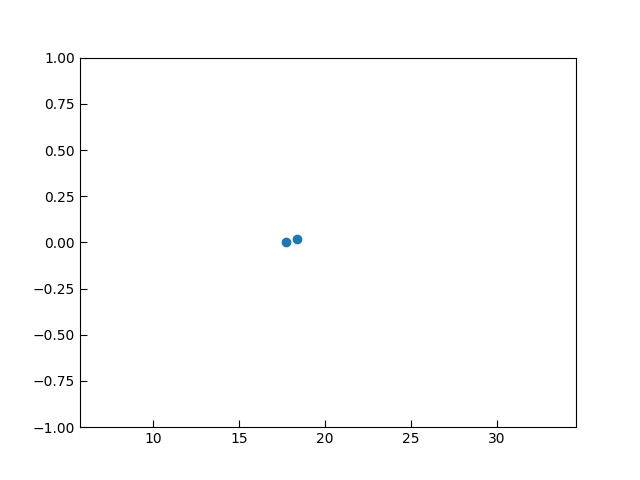

In [38]:
fig,ax = plt.subplots()
ax.scatter(fits_arm2.arm_length, fits_arm2.gamma)
ax.set_ylim(-1,1)

In [39]:
dist_previous = []
for i in range(len(df_tracing_arm1)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm1.iloc[i-1].x
        y1 = df_tracing_arm1.iloc[i-1].y
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))


df_tracing_arm1['dist_previous'] = dist_previous
df_tracing_arm1['arm_length'] = df_tracing_arm1.dist_previous.cumsum()

In [40]:
fits_arm1['arm_length'] = fits_arm1.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm1), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(-1.0, 1.0)

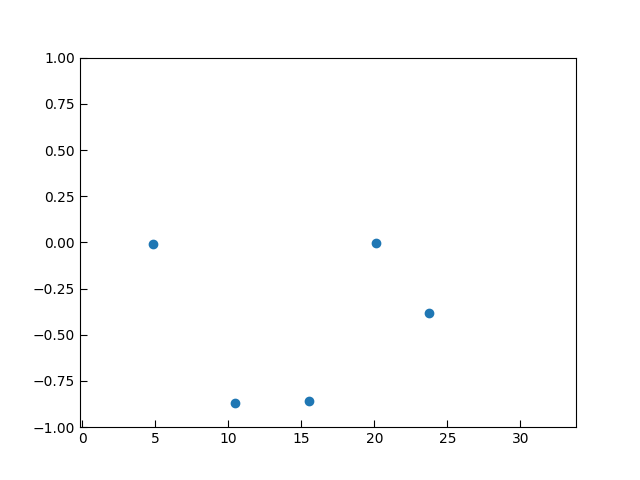

In [41]:
fig,ax = plt.subplots()
ax.scatter(fits_arm1.arm_length, fits_arm1.gamma)
ax.set_ylim(-1,1)

NameError: name 'arm1' is not defined

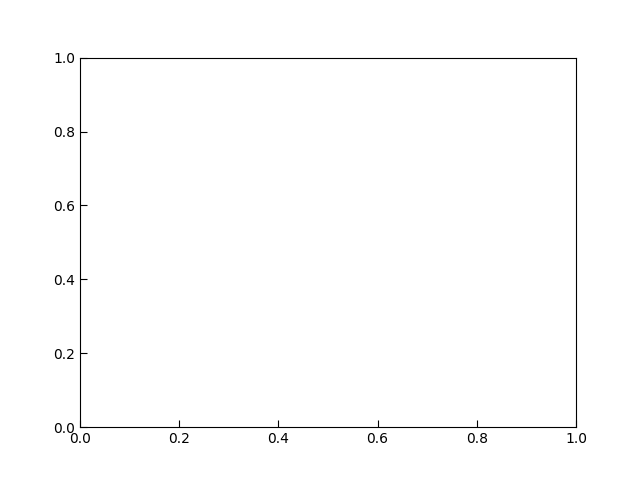

In [42]:
fig, ax = plt.subplots()
ax.plot(arm1.x_tracing, arm1.y_tracing)
ax.plot(arm2.x_tracing, arm2.y_tracing)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

In [ ]:
#df_fits.head
#print(df_fits["amplitude"], df_fits["center"], df_fits["sigma"],  df_fits["gamma"], df_fits["x_tracing"], df_fits["y_tracing"], df_fits["x_max"], df_fits["y_max"], df_fits["w1"], df_fits["w2"], df_fits["arm"], df_fits["fractured"])
#print(df_fits["w1"], df_fits["w2"])
#df_fits.to_csv('Arm_width_rho.csv')

In [ ]:
df_print = pd.DataFrame(zip(df_fits.amplitude, df_fits.center, df_fits.sigma, df_fits.gamma, df_fits.x_tracing, df_fits.y_tracing, df_fits.x_max, df_fits.y_max, df_fits.w1, df_fits.w2, df_fits.arm, df_fits.fractured, df_fits.id_tracing))


In [ ]:
df_print.to_csv('Arm2_widths_rho_adicionales_Ago4.csv')

In [ ]:
def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Verificar que x_eval y y_eval no estén vacíos
    if len(x_eval) == 0 or len(y_eval) == 0:
        print(f"Advertencia: 'x_eval' o 'y_eval' están vacíos para params id: {params.get('id_tracing', 'desconocido')}")
        return {'x_max': np.nan, 'y_max': np.nan, 'w1': np.nan, 'w2': np.nan}

    # Continúa si no están vacíos
    x_max, y_max = find_maximum(x_eval, y_eval)

    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []
    if isinstance(intersection, MultiPoint):
        points_intercept = list(intersection)
    elif not intersection.is_empty:
        points_intercept = [intersection]

    points_intercept = [[point.x, point.y] for point in points_intercept]

    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}



df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)